Установка библиотек

In [ ]:
! pip install -q -U albumentations
! pip install -q wandb
! pip install -q torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.7/125.7 kB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.5/188.5 kB 21.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 214.7/214.7 kB 11.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 729.2/729.2 kB 9.8 MB/s eta 0:00:00


Подключение библиотек

In [ ]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torchmetrics

import os
import numpy as np
import albumentations as album
import cv2
from PIL import Image

import wandb

Создание модели ResNet32

In [ ]:
class ResidualBlock(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, rate=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes * 4, kernel_size=3, stride=stride,
                               dilation=rate, padding=rate, bias=False)
        self.bn2 = nn.BatchNorm2d(planes * 4)

        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride
        self.rate = rate

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out

class ResNet(nn.Module):
    def __init__(self, nInputChannels, block, layers, output_stride=16):
        self.inplanes = 16
        self.output_stride = output_stride
        super(ResNet, self).__init__()
        if self.output_stride == 16:
            strides = [1, 2, 2, 1]
            rates = [1, 1, 1, 2]
            blocks = [1, 2, 4]
        elif self.output_stride == 8:
            strides = [1, 2, 1, 1]
            rates = [1, 1, 2, 2]
            blocks = [1, 2, 1]
        else:
            raise NotImplementedError

        self.conv1 = nn.Conv2d(nInputChannels, 16, kernel_size=7, stride=2, padding=3,
                                bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(block, 16, layers[0], stride=strides[0], rate=rates[0])
        self.layer2 = self._make_layer(block, 32, layers[1], stride=strides[1], rate=rates[1])
        self.layer3 = self._make_layer(block, 64, layers[2], stride=strides[2], rate=rates[2])
        self.layer4 = self._make_MG_unit(block, 512, blocks=blocks, stride=strides[3], rate=rates[3])

        self._init_weight()

    def _make_layer(self, block, planes, blocks, stride=1, rate=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, rate, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def _make_MG_unit(self, block, planes, blocks=[1,2,4], stride=1, rate=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, rate=blocks[0]*rate, downsample=downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, len(blocks)):
            layers.append(block(self.inplanes, planes, stride=1, rate=blocks[i]*rate))

        return nn.Sequential(*layers)

    def forward(self, input):
        x = self.conv1(input)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        low_level_feat = x
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        return x, low_level_feat

    def _init_weight(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                torch.nn.init.kaiming_normal_(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

def ResNet32(nInputChannels=3, output_stride=16, pretrained=False):
    model = ResNet(nInputChannels, ResidualBlock, [3, 4, 4], output_stride)
    return model

Создние модели DeepLabV3Plus с энкодером на ResNet32

In [ ]:
class ASPP_module(nn.Module):
    def __init__(self, inplanes, planes, rate):
        super(ASPP_module, self).__init__()
        if rate == 1:
            kernel_size = 1
            padding = 0
        else:
            kernel_size = 3
            padding = rate
        self.atrous_convolution = nn.Conv2d(inplanes, planes, kernel_size=kernel_size,
                                            stride=1, padding=padding, dilation=rate, bias=False)
        self.bn = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU()

        self._init_weight()

    def forward(self, x):
        x = self.atrous_convolution(x)
        x = self.bn(x)

        return self.relu(x)

    def _init_weight(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                torch.nn.init.kaiming_normal_(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()


class DeepLabv3_plus(nn.Module):
    def __init__(self, nInputChannels=3, n_classes=21, os=16):
        super(DeepLabv3_plus, self).__init__()

        self.resnet_features = ResNet32(nInputChannels, os)

        if os == 16:
            rates = [1, 6, 12, 18]
        elif os == 8:
            rates = [1, 12, 24, 36]
        else:
            raise NotImplementedError

        self.aspp1 = ASPP_module(2048, 64, rate=rates[0])
        self.aspp2 = ASPP_module(2048, 64, rate=rates[1])
        self.aspp3 = ASPP_module(2048, 64, rate=rates[2])
        self.aspp4 = ASPP_module(2048, 64, rate=rates[3])

        self.relu = nn.ReLU()

        self.global_avg_pool = nn.Sequential(nn.AdaptiveAvgPool2d((1, 1)),
                                             nn.Conv2d(2048, 64, 1, stride=1, bias=False),
                                             nn.BatchNorm2d(64),
                                             nn.ReLU())

        self.conv1 = nn.Conv2d(320, 64, 1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)

        self.conv2 = nn.Conv2d(64, 48, 1, bias=False)
        self.bn2 = nn.BatchNorm2d(48)

        self.last_conv = nn.Sequential(nn.Conv2d(112, 64, kernel_size=3, stride=1, padding=1, bias=False),
                                       nn.BatchNorm2d(64),
                                       nn.ReLU(),
                                       nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1, bias=False),
                                       nn.BatchNorm2d(64),
                                       nn.ReLU(),
                                       nn.Conv2d(64, n_classes, kernel_size=1, stride=1))

    def forward(self, input):
        x, low_level_features = self.resnet_features(input)
        x1 = self.aspp1(x)
        x2 = self.aspp2(x)
        x3 = self.aspp3(x)
        x4 = self.aspp4(x)
        x5 = self.global_avg_pool(x)
        x5 = F.upsample(x5, size=x4.size()[2:], mode='bilinear', align_corners=True)
        x = torch.cat((x1, x2, x3, x4, x5), dim=1)
        x = self.conv1(x)

        x = self.bn1(x)
        x = self.relu(x)
        x = F.upsample(x, size=(int(math.ceil(input.size()[-2]/4)),
                                int(math.ceil(input.size()[-1]/4))), mode='bilinear', align_corners=True)
        low_level_features = self.conv2(low_level_features)
        low_level_features = self.bn2(low_level_features)
        low_level_features = self.relu(low_level_features)

        x = torch.cat((x, low_level_features), dim=1)
        x = self.last_conv(x)
        x = F.upsample(x, size=input.size()[2:], mode='bilinear', align_corners=True)
        return x

    def freeze_bn(self):
        for m in self.modules():
            if isinstance(m, nn.BatchNorm2d):
                m.eval()

    def __init_weight(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                torch.nn.init.kaiming_normal_(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

def get_1x_lr_params(model):
    b = [model.resnet_features]
    for i in range(len(b)):
        for k in b[i].parameters():
            if k.requires_grad:
                yield k


def get_10x_lr_params(model):
    b = [model.aspp1, model.aspp2, model.aspp3, model.aspp4, model.conv1, model.conv2, model.last_conv]
    for j in range(len(b)):
        for k in b[j].parameters():
            if k.requires_grad:
                yield k

Загрузка данных с kaggle https://www.kaggle.com/datasets/santurini/semantic-segmentation-drone-dataset. Для обучения используется classes_dataset с уменьшенным количеством классов (5 шт)

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

! pip install kaggle --quiet

! mkdir ~/.kaggle
! cp /content/drive/MyDrive/kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

! kaggle datasets download -d santurini/semantic-segmentation-drone-dataset

! unzip ../content/semantic-segmentation-drone-dataset.zip -d kaggle_data

drive.flush_and_unmount()

Mounted at /content/drive
mkdir: cannot create directory ‘/root/.kaggle’: File exists
... resuming from 3355443200 bytes (1829561147 bytes left) ...
100% 4.83G/4.83G [01:33<00:00, 19.2MB/s]
100% 4.83G/4.83G [01:33<00:00, 19.5MB/s]
Archive:  ../content/semantic-segmentation-drone-dataset.zip
  inflating: kaggle_data/binary_dataset/binary_dataset/images_semantic/000.png  
  inflating: kaggle_data/binary_dataset/binary_dataset/images_semantic/001.png  
  inflating: kaggle_data/binary_dataset/binary_dataset/images_semantic/002.png  
  inflating: kaggle_data/binary_dataset/binary_dataset/images_semantic/003.png  
  inflating: kaggle_data/binary_dataset/binary_dataset/images_semantic/004.png  
  inflating: kaggle_data/binary_dataset/binary_dataset/images_semantic/005.png  
  inflating: kaggle_data/binary_dataset/binary_dataset/images_semantic/006.png  
  inflating: kaggle_data/binary_dataset/binary_dataset/images_semantic/008.png  
  inflating: kaggle_data/binary_dataset/binary_dataset/image

Объявление цветовых значений классов в формате RGB

In [ ]:
class_rgb_values = [[155, 38, 182], [14, 135, 204], [124, 252, 0], [255, 20, 147], [169, 169, 169]]

Создание вспомогательной функции для преобразования метки в формат выхода сети

In [ ]:
def one_hot_encode(label, label_values):
    semantic_map = []
    for colour in label_values:
        equality = np.equal(label, colour)
        class_map = np.all(equality, axis = -1)
        semantic_map.append(class_map)
    semantic_map = np.stack(semantic_map, axis=-1)

    return semantic_map

Создание функции аугментации данных

In [ ]:
def get_training_augmentation():
    train_transform = [
        album.RandomCrop(height=512, width=512, always_apply=True),
        album.OneOf(
            [
                album.HorizontalFlip(p=1),
                album.VerticalFlip(p=1),
                album.RandomRotate90(p=1),
            ],
            p=0.75,
        ),
    ]
    return album.Compose(train_transform)

Создание функции преобразования маски в одноканальное изображение

In [ ]:
def reverse_one_hot(image):
    x = np.argmax(image.numpy(), axis = 0)
    return x

Создание функции преобразования одноканальной маски в маску с соответствующими цветами для отображения результатов

In [ ]:
def colour_code_segmentation(image, label_values):
    colour_codes = np.array(label_values)
    x = colour_codes[image.astype(int)]
    x =  Image.fromarray(x.astype('uint8'), 'RGB')
    return x

Определение класса для работы с набором изображений и соответствующими им метками

In [ ]:
class BuildingsDataset(torch.utils.data.Dataset):

    def __init__(
            self,
            images_dir,
            masks_dir,
            class_rgb_values=None,
            augmentation=None,
    ):

        self.image_paths = [os.path.join(images_dir, image_id) for image_id in sorted(os.listdir(images_dir))]
        self.mask_paths = [os.path.join(masks_dir, image_id) for image_id in sorted(os.listdir(masks_dir))]


        self.images = [cv2.cvtColor(cv2.imread(i), cv2.COLOR_BGR2RGB) for i in self.image_paths]
        self.masks = [cv2.cvtColor(cv2.imread(i), cv2.COLOR_BGR2RGB) for i in self.mask_paths]

        self.class_rgb_values = class_rgb_values
        self.augmentation = augmentation

    def __getitem__(self, i):

        image = self.images[i]
        mask = self.masks[i]
        # image = cv2.cvtColor(cv2.imread(self.image_paths[i]), cv2.COLOR_BGR2RGB)
        # mask = cv2.cvtColor(cv2.imread(self.mask_paths[i]), cv2.COLOR_BGR2RGB)

        mask = one_hot_encode(mask, self.class_rgb_values).astype('float')

        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        image = image.transpose((2, 0, 1))
        image = image / 255.0
        mask = mask.transpose((2, 0, 1))


        return torch.as_tensor(image.copy()).float().contiguous(), torch.as_tensor(mask.copy()).float().contiguous()

    def __len__(self):
        return len(self.image_paths)

Сохдание функтора преобразования тензора в изображение

In [ ]:
transformToPILImage = transforms.ToPILImage()

Создание объекта класса dataset с ранее загруженными данными, цветовыми значениями классов и вспомогательной функцией аугументации

In [ ]:
images_dir = r"../content/kaggle_data/classes_dataset/classes_dataset/original_images/"
masks_dir = r"../content/kaggle_data/classes_dataset/classes_dataset/label_images_semantic/"
kaggle_dataset = BuildingsDataset(images_dir, masks_dir, class_rgb_values=class_rgb_values, augmentation=get_training_augmentation())

Проверка работы класса dataset

In [ ]:
image, mask = kaggle_dataset[0]
show_image = transformToPILImage(image)
show_mask = colour_code_segmentation(reverse_one_hot(mask), class_rgb_values)

Отображение изображения

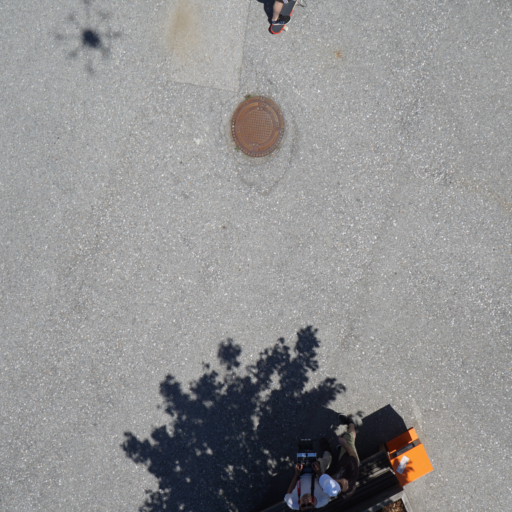

In [ ]:
show_image

Отображение маски

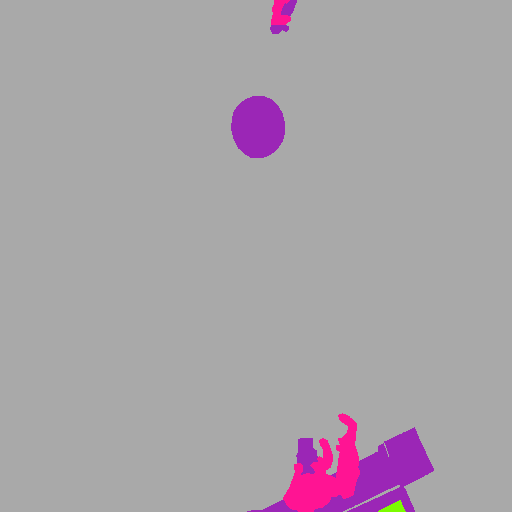

In [ ]:
show_mask

Разделение выборки на тренировочную и валидационную в соотношении 80% тренировочная, 20% валидационная, а таже создание объектов класса DataLoader

In [ ]:
train_size = int(0.8 * len(kaggle_dataset))
test_size = len(kaggle_dataset) - train_size
train_dataset, valid_dataset = torch.utils.data.random_split(kaggle_dataset, [train_size, test_size], generator=torch.Generator().manual_seed(0))

print(len(train_dataset), len(valid_dataset))

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=1, shuffle=False, num_workers=1)

320 80


Создание функции потерь

In [ ]:
def dice_coeff(input, target, reduce_batch_first: bool = False, epsilon: float = 1e-6):
    assert input.size() == target.size()
    assert input.dim() == 3 or not reduce_batch_first

    sum_dim = (-1, -2) if input.dim() == 2 or not reduce_batch_first else (-1, -2, -3)

    inter = 2 * (input * target).sum(dim=sum_dim)
    sets_sum = input.sum(dim=sum_dim) + target.sum(dim=sum_dim)
    sets_sum = torch.where(sets_sum == 0, inter, sets_sum)

    dice = (inter + epsilon) / (sets_sum + epsilon)
    return dice.mean()


def multiclass_dice_coeff(input, target, reduce_batch_first: bool = False, epsilon: float = 1e-6):
    return dice_coeff(input.flatten(0, 1), target.flatten(0, 1), reduce_batch_first, epsilon)


def dice_loss(input, target, multiclass: bool = False):
    fn = multiclass_dice_coeff if multiclass else dice_coeff
    return 1 - fn(input, target, reduce_batch_first=True)

Расчет количества каждого класса в наборе данных для дальнейшей балансировки классов, но на данный момент это не реализованно

In [ ]:
weight_balance = [0 for i in range(0, len(class_rgb_values))]
for images, masks in kaggle_dataset:
  # for idx, channel in enumerate(mask.numpy()):
    # weight_balance[idx] += np.count_nonzero(channel)
  weight_balance[0] += np.count_nonzero(masks.numpy()[0])
  weight_balance[1] += np.count_nonzero(masks.numpy()[1])
  weight_balance[2] += np.count_nonzero(masks.numpy()[2])
  weight_balance[3] += np.count_nonzero(masks.numpy()[3])
  weight_balance[4] += np.count_nonzero(masks.numpy()[4])

print(weight_balance)


In [ ]:
# class_weights = torch.FloatTensor([0.5, 1, 1, 1, 0.05]).to(device=device)

Создание объекта класса модели с заданными параметрами, установка количества эпох обучения, выбор устройства для обучения, определение функции потерь и планировщика обучения

In [ ]:
model = DeepLabv3_plus(nInputChannels=3, n_classes=5, os=16)

epochs = 50
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

criterion = nn.CrossEntropyLoss()

# optimizer = torch.optim.RMSprop(model.parameters(), lr=0.01,
#                          weight_decay=0, momentum=0, foreach=True)
optimizer = torch.optim.Adam(model.parameters())

# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5)

scheduler =  torch.optim.lr_scheduler.StepLR(optimizer, step_size=40, gamma=0.1)



Подготовка скорости обучения для разминки модели

In [ ]:
for g in optimizer.param_groups:
      g['lr'] /= 1000

Метрика Жаккара для обучения

In [ ]:
jaccard = torchmetrics.classification.MulticlassJaccardIndex(num_classes=5)

Инициализация объекта Weights & Biases для логирования

In [ ]:
# !wandb login --relogin

In [ ]:
wandb.login()
experiment = wandb.init(project='DeepLabV3plus', resume='allow')

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


epoch,▁▂▄▅▇█
train dice loss,█▇▄▂▂▁
train loss,█▆▃▂▂▁
valid dice loss,▆▆▅█▃▁
valid jaccard,▅▅▄▁▇█
valid pixel accuracy,█▅▃▁▅▇
epoch,5
train dice loss,2.87393
train loss,10.08196
valid dice loss,44.99249
valid jaccard,13.72103


Обучение и валидация модели, расчет метрик обучения, сохранение примеров изображений

In [ ]:
model.to(device=device)
for epoch in range(0, epochs):
  epoch_dice_loss = 0
  epoch_loss = 0

  if epoch < 3:
    for g in optimizer.param_groups:
      g['lr'] *= 10


  model.train()
  for images, masks in train_loader:
    images = images.to(device=device, dtype=torch.float32)
    masks = masks.to(device=device, dtype=torch.float32)

    masks_pred = model(images)

    loss0 = criterion(masks_pred, masks)
    loss1 = dice_loss(
        F.softmax(masks_pred, dim=1).float(),
        masks,
        multiclass=True
    )
    loss = loss0 + loss1

    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

    epoch_loss += loss.cpu().detach().item()
    epoch_dice_loss += loss1

    if epoch > 3:
      scheduler.step()
      # scheduler.step(loss1)


  val_dice_loss = 0
  val_epoch_jaccard = 0
  val_epoch_pixel_accuracy = 0

  model.eval()
  for idx, data in enumerate(valid_loader):
    images, masks = data
    images = images.to(device=device, dtype=torch.float32)
    masks = masks.to(device=device, dtype=torch.float32)

    masks_pred = model(images)

    loss_val = dice_loss(
        F.softmax(masks_pred, dim=1).float(),
        masks,
        multiclass=True
    )

    val_dice_loss += loss_val.item()
    val_epoch_jaccard += jaccard(F.softmax(masks_pred.cpu().detach(), dim=1), torch.argmax(masks.cpu().detach(), dim=1))
    val_epoch_pixel_accuracy += (torch.argmax(masks_pred.cpu().detach(), dim=1) == torch.argmax(masks.cpu().detach(), dim=1)).sum().item()

    if idx % 20 == 0:
      original_image = transformToPILImage(images[0].cpu().detach())
      true_mask = colour_code_segmentation(reverse_one_hot(masks[0].cpu().detach()), class_rgb_values)
      pred_mask = colour_code_segmentation(reverse_one_hot(masks_pred[0].cpu().detach()), class_rgb_values)
      experiment.log({
          'images': wandb.Image(original_image),
          'image with true mask': wandb.Image(Image.blend(original_image, true_mask, 0.5)),
          'image with pred mask': wandb.Image(Image.blend(original_image, pred_mask, 0.5)),
          'true pred mask': wandb.Image(Image.blend(true_mask, pred_mask, 0.25))
          })

  experiment.log({
          'epoch': epoch,
          'train loss': epoch_loss,
          'train dice loss': epoch_dice_loss.cpu().detach().item(),
          'valid dice loss': val_dice_loss,
          'valid jaccard': val_epoch_jaccard,
          'valid pixel accuracy': val_epoch_pixel_accuracy
      })




KeyboardInterrupt: ignored